In [85]:
import os
import random
import time

import lightgbm as lightgbm
import pandas as pd
import numpy as np
import xgboost as xgboost
from sklearn import model_selection
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier, \
    BaggingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso, ElasticNet, LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
import pickle
from boostaroota import BoostARoota
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

DATA_PATH = '.'
# INPUT_DATA_TRAIN = os.path.join(DATA_PATH, 'input.csv')
# OUTPUT_DATA_TRAIN = os.path.join(DATA_PATH, 'output.csv')

input_df = pickle.load(open( "./full_train.pkl", "rb" ))

x_df = pickle.load(open( "./allstations_train_x.pkl", "rb" ))
y_df = pickle.load(open( "./allstations_train_y.pkl", "rb" ))


dict_names = {
    'B00300S' : 'Air-temperature',
    'B00305A' :	'Soil-temperature',
    'B00202A' : 'Wind-direction',
    'B00702A' : 'Avg-wind-speed-past-10-mts',
    'B00703A' : 'Max-speed',
    'B00608S' : 'Precipitation-sum-past-10-mts',
    'B00604S' : 'Precipitation-sum-past-24-hrs',
    'B00606S' : 'Precipitation-sum-past-1-hrs',
    'B00802A' : 'Relative-humidity',
    'B00714A' : 'Max-wind-past-10-mts',
    'B00910A' : 'Water-in-snow'
}

def fix_column_names(df, d):
    rename_d = {}
    for column in df.columns:
        column_list = column.split("_")
        station_name = column_list[1]
        coded_name = column_list[0]
        suffix = coded_name
        if coded_name in d:
            suffix = d[coded_name]
        rename_d[coded_name+'_'+station_name] = suffix+"_"+station_name
    df.rename(columns=rename_d,inplace=True)
    return df

def timing(f):
    def wrap(*args):
        time1 = time.time()
        ret = f(*args)
        time2 = time.time()
        print('{:s} function took {:.3f} ms'.format(f.__name__, (time2 - time1) * 1000.0))
        return ret

    return wrap

def prepare_data(data):
    # data = data.drop(columns=['data_'])
    y=None
    if 'is_rain' in data:
        y = data['is_rain']
        X = data.drop(columns=['is_rain'])
    else:
        X = data
    if 'data_' in data:
        X = data.drop(columns=['data_'])
    if 'is_rain' in X:
        X = X.drop(columns=['is_rain'])
    if 'date' in X:
        X = X.drop(columns='date')
    print(X.isnull().values.any())
    X.fillna(method='ffill', inplace=True)
    X.fillna(method='bfill', inplace=True)
    print(X.isnull().values.any())
    X = fix_column_names(X, dict_names)
    return X, y

def prepare_train_test(X,y):
    # y_with_one_indices = y.index[y == 1].tolist()
    # y_with_zero_indices = y.index[y == 0].tolist()
    # y_ones = y[y_with_one_indices]
    # x_ones = X.loc[y_with_one_indices]
    # y_zero = y[y_with_zero_indices][:len(y_ones)]
    # x_zero = X.loc[y_with_zero_indices][:len(y_ones)]
    #
    # X = pd.concat([x_zero, x_ones])
    # y = pd.concat([y_zero, y_ones])

    # idx = np.random.permutation(x_zero.index)
    # x_zero.reindex(idx)
    # y_zero.reindex(idx)
    #
    # x_zero

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
    # X_test = X[:140]
    # X_train = X[140:]
    # y_test = y[:140]
    # y_train = y[140:]
    # d_1 = boostaroota(X, y)
    # print('boruta')
    # a_1 = boruta(X.values, y)
    # print('rfecv')
    # b_1 = rfe(X.values, y)
    print('rf')
    X_train = X
    y_train = y
#     X_train_selected, selected_features, rank = boruta(X_train, y_train)
    X_train_selected, selected_features = rf(X_train, y_train)
    # X_train_selected, selected_features = rfe(X_train, y_train)
    print(selected_features)
#     ranking = 
    X_test_selected = X_test[selected_features]


    x_standard_scaler = StandardScaler()
    X_train_selected_transformed = x_standard_scaler.fit_transform(X_train_selected)
    X_test_selected_transformed = x_standard_scaler.transform(X_test_selected)

    y_label_encoder = LabelEncoder()
    y_train_encoded = y_label_encoder.fit_transform(y_train)
    y_test_encoded = y_label_encoder.transform(y_test)

    return X_train_selected_transformed, X_test_selected_transformed, y_train_encoded, y_test_encoded


# def divide_train_test(X,y):
def boostaroota(df_x, df_y):
    br = BoostARoota(metric='f1')
    br.fit(df_x, df_y)
    df_x_selected = br.fit_transform(df_x, df_y)
    return df_x_selected

@timing
def boruta(df_x, df_y):
    columns = list(df_x.columns)
    df_x = df_x.values
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
    df_x_selected = feat_selector.fit_transform(df_x, df_y)
#     for (f,i) in zip(columns, feat_selector.support_):
#         if i == True:
#             selected_cols.append(f)
    rank = feat_selector.ranking_
    selected_cols = []
    for (f, i) in zip(columns, feat_selector.support_):
        if i == True:
            selected_cols.append(f)

    tups = [(r,f) for r,f in zip(rank, selected_cols)]
    print(sorted(tups, key=lambda x: x[0], reverse=True))
    return df_x_selected, selected_cols, feat_selector.ranking_,sorted(zip(map(lambda x: round(x, 4), rank), selected_cols),
            reverse=True)  #, list(df_x_selected.columns)

@timing
def rfe(df_x, df_y):
    columns = list(df_x.columns)
    rfc = RandomForestClassifier(random_state=101)
    rfecv = RFECV(estimator=rfc, step=3,
                     cv=StratifiedKFold(2), scoring='f1_weighted')
    # rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(2), scoring="f1_weighted")
    df_x_selected = rfecv.fit_transform(df_x, df_y)
    print(df_x_selected.shape)
    selected_cols = []
    for (f, i) in zip(columns, rfecv.support_):
        if i == True:
            selected_cols.append(f)
    return df_x_selected, selected_cols #, list(df_x_selected.columns)

@timing
def rf(df_x, df_y):
    rf = RandomForestClassifier(n_jobs=-1, random_state=1, n_estimators=20)
    columns = list(df_x.columns)
    SEED = 448
    random.seed(SEED)
    random.shuffle(columns)
    df_x = df_x[columns]
    rf.fit(df_x, df_y)
    names = df_x.columns
    feat_imp = rf.feature_importances_
#     print ("Features sorted by their score:")
#     print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),
#            reverse=True))
    print(feat_imp)
    feats_selected = df_x.columns[feat_imp > 0.01]
    # print(df_x_selected.shape)
    return df_x[feats_selected], feats_selected, feat_imp, sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),
            reverse=True)  
                                                                 #, list(df_x_selected.columns)

# class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, models):
#         self.models_ = models
#
#     def fit(self, X, y):
#         for model in self.models_:
#             model.fit(X, y)
#
#     def predict(self, X):
#         predictions = np.column_stack([
#             model.predict(X) for model in self.models_
#         ])
#         return np.mean(predictions, axis=1)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        # self.models_ = models
        self.voting_classifier = VotingClassifier(estimators=[models], voting='hard')

    def fit(self, X, y):
        self.voting_classifier.fit(X, y)

    def predict(self, X):
        return self.voting_classifier.predict(X)

    # > eclf3 = VotingClassifier(estimators=[
    #     ...('lr', clf1), ('rf', clf2), ('gnb', clf3)],
    #     ...
    # voting = 'soft', weights = [2, 1, 1],
    #                            ...
    # flatten_transform = True)
    # >> > eclf3 = eclf3.fit(X, y)
    # >> > print(eclf3.predict(X))

def return_models():
        models = []

        ### random forest model
        models.append( ('rf', RandomForestClassifier(max_depth=5, random_state=42, n_estimators=5,
                                         verbose=0) ) ) # Train the model on training data
        models.append( ('knn', KNeighborsClassifier(3)) )

        models.append(('svc',SVC(kernel="linear", C=0.025)))
        models.append(('dt', DecisionTreeClassifier(max_depth=5)))
        models.append(('ada', AdaBoostClassifier()))
        models.append(('gaussian', GaussianNB()))
        # models.append(('nusvc', NuSVC()))
        models.append(('linear_svc', LinearSVC(max_iter=10000)))
        models.append(('sgd_classifier', SGDClassifier()))
        models.append(('logisit_reg',LogisticRegressionCV(max_iter=10000)))
        models.append(('bagging_classifier', BaggingClassifier()))
        models.append(('extra_trees', ExtraTreesClassifier()))

        return models


#####################

# X = pd.read_csv('./examples/test_X', index_col=0)
# y = pd.read_csv('./examples/test_y', header=None, index_col=0)
# y = y.ravel()

# X = pickle.load(open())
X = x_df
y = y_df
X_train_selected, selected_features, feat_imp, mapa = boruta(X, y)
# X_train, X_test, y_train, y_test = prepare_train_test(X, y)
# X_test, y_test = prepare_data(test_df)
#
# x_standard_scaler = StandardScaler()
# X_train_selected_transformed = x_standard_scaler.fit_transform(X_train)
# X_test_selected_transformed = x_standard_scaler.transform(X_test)
#
# y_label_encoder = LabelEncoder()
# y_train_encoded = y_label_encoder.fit_transform(y_train)
# # y_test_encoded = y_label_encoder.transform(y_test)
#
# # X_train, X_test, y_train, y_test = prepare_train_test(X,y)
# models = return_models()
# voting_classifier = VotingClassifier(estimators=models, voting='hard')
# voting_classifier.fit(X_train, y_train)
# cv = model_selection.cross_val_score(voting_classifier, X_train, y_train,cv=10, scoring='f1')
# print(cv)
# print(np.mean(cv))
# y_pred = voting_classifier.predict(X_test)
# print('f1 score {}'.format(f1_score(y_test, y_pred, zero_division=1)))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	2968
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	354
Tentative: 	694
Rejected: 	1920
Iteration: 	9 / 100
Confirmed: 	354
Tentative: 	694
Rejected: 	1920
Iteration: 	10 / 100
Confirmed: 	354
Tentative: 	694
Rejected: 	1920
Iteration: 	11 / 100
Confirmed: 	354
Tentative: 	694
Rejected: 	1920
Iteration: 	12 / 100
Confirmed: 	358
Tentative: 	534
Rejected: 	2076
Iteration: 	13 / 100
Confirmed: 	358
Tentative: 	534
Rejected: 	2076
Iteration: 	14 / 100
Confirmed: 	358
Tentative: 	534
Rejected: 	2076
Iteration: 	15 / 100
Confirmed: 	358
Tentative: 	534
Rejected: 	2076
It

In [87]:
# feat_imp
# mapa
# selected_features
mapa = mapa[:30]

stations = set()
features = set()

for m in mapa:
    msplit = m[1].split('_')
    stations.add(msplit[0])
    features.add(msplit[1])

stations = list(stations)
features = list(features)
print(len(stations))
print(len(features))

array = [[0 for i in range(len(features))] for j in range(len(stations))]
# array[0][0] = 100
# print(array)

for m in mapa:
    msplit = m[1].split('_')
    station = msplit[0]
    feature = msplit[1]
    val = m[0]
    station_idx = stations.index(station)
    feature_idx = features.index(feature)
#     print('{} {}'.format(station_idx, feature_idx))
    array[station_idx][feature_idx] = val
#     print(array)
print(array)

    

26
7
[[0, 0, 0, 0, 1753, 0, 0], [0, 0, 0, 1544, 0, 0, 0], [0, 1665, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1579, 0], [0, 1538, 0, 0, 0, 0, 0], [0, 0, 0, 1511, 0, 0, 0], [0, 1587, 0, 0, 0, 0, 0], [0, 1514, 0, 0, 0, 0, 1649], [0, 0, 0, 0, 0, 0, 1637], [0, 0, 0, 0, 1540, 1668, 1592], [0, 0, 0, 0, 0, 0, 1564], [0, 0, 1624, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1530], [0, 0, 0, 0, 0, 1520, 1651], [0, 0, 0, 0, 0, 1572, 0], [0, 0, 0, 0, 0, 0, 1635], [0, 0, 0, 0, 0, 0, 1854], [0, 0, 0, 0, 0, 0, 1540], [1778, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1691, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1671], [0, 0, 0, 0, 1584, 0, 0], [0, 0, 0, 0, 0, 0, 1623], [0, 0, 0, 1661, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1622], [0, 0, 0, 0, 0, 0, 1613]]


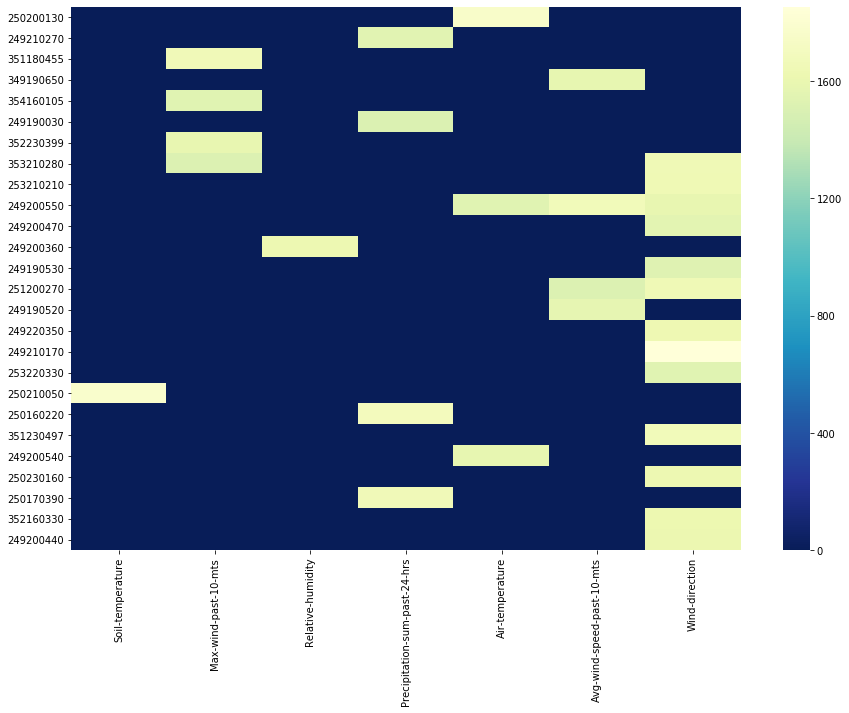

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
 
# a = np.random.random((16, 16))
plt.figure(figsize=(15,10))
heat_map = sb.heatmap(array,cmap="YlGnBu_r", xticklabels=features, yticklabels=stations)
# plt.figure(figsize=(20,15))
figure = heat_map.get_figure()    
figure.savefig('./output_heatmap.png', dpi=100)
# heat_map.savefig('./output_heatmap.png')

In [ ]:
x_df = pickle.load(open( "./allstations_train_x.pkl", "rb" ))
y_df = pickle.load(open( "./allstations_train_y.pkl", "rb" ))

In [13]:
y_df

In [19]:
a = [(1854, '249210170_Wind-direction'), (1778, '250210050_Soil-temperature'), (1753, '250200130_Air-temperature'), (1691, '250160220_Precipitation-sum-past-24-hrs'), (1671, '351230497_Wind-direction'), (1668, '249200550_Avg-wind-speed-past-10-mts'), (1665, '351180455_Max-wind-past-10-mts'), (1661, '250170390_Precipitation-sum-past-24-hrs'), (1651, '251200270_Wind-direction'), (1649, '353210280_Wind-direction'), (1637, '253210210_Wind-direction'), (1635, '249220350_Wind-direction'), (1624, '249200360_Relative-humidity'), (1623, '250230160_Wind-direction'), (1622, '352160330_Wind-direction'), (1613, '249200440_Wind-direction'), (1592, '249200550_Wind-direction'), (1587, '352230399_Max-wind-past-10-mts'), (1584, '249200540_Air-temperature'), (1579, '349190650_Avg-wind-speed-past-10-mts'), (1572, '249190520_Avg-wind-speed-past-10-mts'), (1564, '249200470_Wind-direction'), (1544, '249210270_Precipitation-sum-past-24-hrs'), (1540, '253220330_Wind-direction'), (1540, '249200550_Air-temperature'), (1538, '354160105_Max-wind-past-10-mts'), (1530, '249190530_Wind-direction'), (1520, '251200270_Avg-wind-speed-past-10-mts'), (1514, '353210280_Max-wind-past-10-mts'), (1511, '249190030_Precipitation-sum-past-24-hrs'), (1510, '351190469_Max-wind-past-10-mts'), (1503, '352230399_Wind-direction'), (1502, '253150250_Precipitation-sum-past-1-hrs'), (1485, '250200010_Precipitation-sum-past-24-hrs'), (1475, '249200440_Avg-wind-speed-past-10-mts'), (1463, '253190070_Wind-direction'), (1457, '249190170_Precipitation-sum-past-24-hrs'), (1454, '350210585_Wind-direction'), (1445, '351160424_Max-wind-past-10-mts'), (1444, '351180435_Max-wind-past-10-mts'), (1441, '254180090_Precipitation-sum-past-24-hrs'), (1438, '353210285_Wind-direction'), (1436, '354190160_Air-temperature'), (1428, '254220030_Wind-direction'), (1428, '253210290_Precipitation-sum-past-24-hrs'), (1427, '254180010_Precipitation-sum-past-24-hrs'), (1425, '249220340_Wind-direction'), (1425, '249200140_Precipitation-sum-past-24-hrs'), (1423, '253230160_Wind-direction'), (1421, '352140310_Avg-wind-speed-past-10-mts'), (1420, '354180155_Precipitation-sum-past-24-hrs'), (1416, '252160110_Wind-direction'), (1399, '254160020_Precipitation-sum-past-24-hrs'), (1371, '249190640_Precipitation-sum-past-24-hrs'), (1345, '249220320_Relative-humidity'), (1325, '249190780_Precipitation-sum-past-24-hrs'), (1321, '250190380_Precipitation-sum-past-24-hrs'), (1317, '249190680_Precipitation-sum-past-24-hrs'), (1310, '250200050_Precipitation-sum-past-24-hrs'), (1310, '253170210_Precipitation-sum-past-24-hrs'), (1307, '249220290_Soil-temperature'), (1305, '353230295_Max-wind-past-10-mts'), (1295, '249210140_Wind-direction'), (1290, '254180260_Precipitation-sum-past-24-hrs'), (1278, '251200270_Soil-temperature'), (1266, '353150210_Max-wind-past-10-mts'), (1254, '249190670_Precipitation-sum-past-24-hrs'), (1243, '353200270_Max-wind-past-10-mts'), (1242, '250190030_Wind-direction'), (1238, '253220270_Wind-direction'), (1225, '249200540_Max-speed'), (1221, '254190070_Precipitation-sum-past-24-hrs'), (1219, '254190160_Precipitation-sum-past-24-hrs'), (1217, '249190530_Avg-wind-speed-past-10-mts'), (1215, '249200550_Max-speed'), (1183, '254200080_Precipitation-sum-past-24-hrs'), (1182, '250230140_Relative-humidity'), (1180, '254190050_Precipitation-sum-past-24-hrs'), (1178, '252150180_Wind-direction'), (1176, '249200540_Avg-wind-speed-past-10-mts'), (1171, '350210585_Max-wind-past-10-mts'), (1169, '253220080_Precipitation-sum-past-24-hrs'), (1166, '352180345_Avg-wind-speed-past-10-mts'), (1159, '352220385_Wind-direction'), (1156, '253150250_Precipitation-sum-past-24-hrs'), (1139, '250160190_Precipitation-sum-past-24-hrs'), (1135, '254190020_Relative-humidity'), (1134, '354220195_Max-wind-past-10-mts'), (1108, '251200270_Precipitation-sum-past-1-hrs'), (1104, '249190430_Precipitation-sum-past-24-hrs'), (1097, '250230140_Wind-direction'), (1092, '352140310_Wind-direction'), (1078, '249200910_Avg-wind-speed-past-10-mts'), (1075, '253190310_Precipitation-sum-past-24-hrs'), (1070, '352190360_Max-wind-past-10-mts'), (1065, '352220385_Max-wind-past-10-mts'), (1059, '249220290_Relative-humidity'), (1053, '249200330_Wind-direction'), (1049, '249180010_Precipitation-sum-past-24-hrs'), (1038, '353200272_Precipitation-sum-past-24-hrs'), (1036, '352200375_Max-wind-past-10-mts'), (1033, '249210070_Precipitation-sum-past-24-hrs'), (1033, '254190020_Precipitation-sum-past-24-hrs'), (1024, '254220020_Precipitation-sum-past-24-hrs'), (1019, '252230120_Wind-direction'), (1018, '252230190_Precipitation-sum-past-24-hrs'), (1007, '249220150_Relative-humidity'), (1001, '253180040_Precipitation-sum-past-24-hrs'), (995, '254220090_Wind-direction'), (992, '350160520_Wind-direction'), (992, '252210240_Precipitation-sum-past-24-hrs'), (991, '349190600_Max-wind-past-10-mts'), (990, '249200440_Soil-temperature'), (989, '249200440_Max-speed'), (986, '354190160_Precipitation-sum-past-24-hrs'), (982, '350230595_Wind-direction'), (962, '253210280_Precipitation-sum-past-24-hrs'), (957, '249200370_Relative-humidity'), (955, '249200130_Precipitation-sum-past-24-hrs'), (946, '249180130_Wind-direction'), (943, '351180435_Precipitation-sum-past-24-hrs'), (933, '251200270_Precipitation-sum-past-10-mts'), (932, '350200575_Max-wind-past-10-mts'), (927, '354160115_Max-wind-past-10-mts'), (926, '249220040_Relative-humidity'), (923, '249190670_Precipitation-sum-past-1-hrs'), (920, '249200350_Precipitation-sum-past-24-hrs'), (915, '252210290_Precipitation-sum-past-24-hrs'), (904, '354170120_Max-wind-past-10-mts'), (896, '254200050_Precipitation-sum-past-24-hrs'), (870, '350230595_Max-wind-past-10-mts'), (867, '249200910_Relative-humidity'), (857, '249210250_Precipitation-sum-past-24-hrs'), (855, '352140310_Max-speed'), (854, '252230230_Precipitation-sum-past-24-hrs'), (852, '352200375_Precipitation-sum-past-24-hrs'), (851, '354170125_Precipitation-sum-past-24-hrs'), (847, '351150400_Wind-direction'), (846, '250230160_Relative-humidity'), (843, '249190530_Max-speed'), (833, '250210240_Relative-humidity'), (813, '250170250_Relative-humidity'), (812, '251180040_Precipitation-sum-past-24-hrs'), (809, '251230120_Wind-direction'), (807, '249210240_Relative-humidity'), (798, '352140310_Precipitation-sum-past-24-hrs'), (795, '249210070_Max-speed'), (793, '350190566_Max-wind-past-10-mts'), (788, '252180260_Precipitation-sum-past-24-hrs'), (786, '254180060_Relative-humidity'), (779, '252190030_Avg-wind-speed-past-10-mts'), (774, '249190480_Wind-direction'), (761, '354180135_Relative-humidity'), (757, '251210040_Wind-direction'), (756, '249190520_Wind-direction'), (755, '249201010_Precipitation-sum-past-24-hrs'), (752, '249190140_Precipitation-sum-past-24-hrs'), (747, '250160410_Precipitation-sum-past-24-hrs'), (745, '353140205_Max-wind-past-10-mts'), (741, '252180080_Precipitation-sum-past-24-hrs'), (733, '249190790_Precipitation-sum-past-24-hrs'), (731, '253180220_Precipitation-sum-past-24-hrs'), (728, '253210170_Precipitation-sum-past-24-hrs'), (722, '250210040_Precipitation-sum-past-24-hrs'), (716, '249190320_Precipitation-sum-past-24-hrs'), (704, '249190050_Precipitation-sum-past-24-hrs'), (701, '253220220_Precipitation-sum-past-24-hrs'), (697, '353210280_Precipitation-sum-past-24-hrs'), (693, '353210285_Precipitation-sum-past-24-hrs'), (691, '249220150_Precipitation-sum-past-24-hrs'), (688, '254200080_Relative-humidity'), (686, '254180010_Relative-humidity'), (680, '350200570_Precipitation-sum-past-24-hrs'), (678, '249200450_Precipitation-sum-past-24-hrs'), (677, '250200250_Precipitation-sum-past-24-hrs'), (667, '353180250_Precipitation-sum-past-24-hrs'), (660, '252220120_Precipitation-sum-past-24-hrs'), (659, '254200070_Precipitation-sum-past-24-hrs'), (652, '251180330_Precipitation-sum-past-24-hrs'), (639, '354180155_Wind-direction'), (635, '351230497_Precipitation-sum-past-24-hrs'), (632, '250170250_Precipitation-sum-past-24-hrs'), (628, '353140200_Precipitation-sum-past-24-hrs'), (626, '251210120_Wind-direction'), (624, '253220330_Precipitation-sum-past-24-hrs'), (619, '252230030_Wind-direction'), (618, '254180140_Precipitation-sum-past-24-hrs'), (613, '354180155_Max-wind-past-10-mts'), (609, '253170160_Precipitation-sum-past-24-hrs'), (605, '253230020_Wind-direction'), (603, '350190550_Wind-direction'), (596, '249200550_Relative-humidity'), (591, '249190770_Precipitation-sum-past-24-hrs'), (589, '354190160_Max-wind-past-10-mts'), (588, '250230070_Wind-direction'), (579, '249220340_Precipitation-sum-past-24-hrs'), (574, '351190469_Precipitation-sum-past-24-hrs'), (574, '350200570_Max-wind-past-10-mts'), (570, '253210210_Precipitation-sum-past-24-hrs'), (564, '254190050_Relative-humidity'), (559, '351210488_Max-wind-past-10-mts'), (553, '354170125_Max-wind-past-10-mts'), (552, '353200272_Max-wind-past-10-mts'), (548, '253180150_Precipitation-sum-past-24-hrs'), (546, '250210050_Air-temperature'), (546, '350190560_Precipitation-sum-past-24-hrs'), (540, '254210020_Precipitation-sum-past-24-hrs'), (539, '353200270_Wind-direction'), (537, '349220695_Relative-humidity'), (535, '254180090_Relative-humidity'), (533, '349190650_Max-speed'), (527, '250160070_Precipitation-sum-past-24-hrs'), (521, '254190120_Precipitation-sum-past-24-hrs'), (517, '351160415_Max-wind-past-10-mts'), (515, '252200120_Wind-direction'), (507, '349210670_Max-wind-past-10-mts'), (501, '354210185_Wind-direction'), (487, '250150110_Precipitation-sum-past-24-hrs'), (477, '249200050_Precipitation-sum-past-24-hrs'), (476, '253190030_Precipitation-sum-past-24-hrs'), (474, '250170330_Precipitation-sum-past-24-hrs'), (470, '249210080_Precipitation-sum-past-24-hrs'), (470, '354150100_Max-wind-past-10-mts'), (466, '353210280_Relative-humidity'), (464, '349190650_Air-temperature'), (458, '349190650_Wind-direction'), (451, '249220310_Precipitation-sum-past-24-hrs'), (444, '249220270_Precipitation-sum-past-24-hrs'), (433, '350150500_Precipitation-sum-past-24-hrs'), (431, '249200470_Precipitation-sum-past-24-hrs'), (428, '254180060_Precipitation-sum-past-24-hrs'), (423, '250150350_Precipitation-sum-past-24-hrs'), (420, '353200270_Precipitation-sum-past-24-hrs'), (416, '353170235_Wind-direction'), (414, '252180310_Precipitation-sum-past-24-hrs'), (406, '249200480_Precipitation-sum-past-24-hrs'), (402, '249200280_Precipitation-sum-past-24-hrs'), (399, '254170040_Precipitation-sum-past-24-hrs'), (399, '352160330_Max-wind-past-10-mts'), (396, '352220385_Precipitation-sum-past-24-hrs'), (394, '249220060_Precipitation-sum-past-24-hrs'), (390, '254180260_Relative-humidity'), (381, '249200210_Precipitation-sum-past-24-hrs'), (371, '351230497_Max-wind-past-10-mts'), (369, '249210230_Wind-direction'), (367, '251190210_Precipitation-sum-past-24-hrs'), (365, '249210340_Precipitation-sum-past-24-hrs'), (362, '250150250_Precipitation-sum-past-24-hrs'), (357, '350220580_Wind-direction'), (349, '249200950_Precipitation-sum-past-24-hrs'), (346, '249220320_Air-temperature'), (346, '249190350_Precipitation-sum-past-24-hrs'), (342, '353200272_Wind-direction'), (340, '249200530_Precipitation-sum-past-24-hrs'), (340, '253180090_Precipitation-sum-past-24-hrs'), (337, '352180345_Max-wind-past-10-mts'), (336, '351220495_Max-wind-past-10-mts'), (332, '249220280_Precipitation-sum-past-24-hrs'), (329, '249190520_Max-speed'), (328, '352200375_Wind-direction'), (326, '253230180_Precipitation-sum-past-24-hrs'), (317, '253200080_Precipitation-sum-past-24-hrs'), (317, '253230030_Precipitation-sum-past-24-hrs'), (314, '354210185_Precipitation-sum-past-24-hrs'), (313, '249200180_Precipitation-sum-past-24-hrs'), (312, '250210080_Precipitation-sum-past-24-hrs'), (308, '253180090_Wind-direction'), (291, '253220310_Precipitation-sum-past-24-hrs'), (289, '249210240_Precipitation-sum-past-24-hrs'), (284, '249210170_Precipitation-sum-past-24-hrs'), (270, '253210370_Precipitation-sum-past-24-hrs'), (269, '249220120_Precipitation-sum-past-24-hrs'), (265, '352180345_Precipitation-sum-past-24-hrs'), (263, '249220260_Precipitation-sum-past-24-hrs'), (262, '249200910_Air-temperature'), (259, '249200260_Precipitation-sum-past-24-hrs'), (257, '249200370_Precipitation-sum-past-24-hrs'), (251, '352150300_Max-wind-past-10-mts'), (250, '251190160_Precipitation-sum-past-24-hrs'), (247, '251200030_Wind-direction'), (241, '349200660_Max-wind-past-10-mts'), (238, '351180455_Wind-direction'), (236, '353230295_Wind-direction'), (234, '249220140_Precipitation-sum-past-24-hrs'), (232, '253210350_Precipitation-sum-past-24-hrs'), (216, '249200440_Precipitation-sum-past-24-hrs'), (206, '250210070_Precipitation-sum-past-24-hrs'), (196, '249220040_Precipitation-sum-past-24-hrs'), (193, '249210260_Precipitation-sum-past-24-hrs'), (180, '249200930_Precipitation-sum-past-24-hrs'), (175, '249200220_Precipitation-sum-past-24-hrs'), (168, '250240010_Precipitation-sum-past-24-hrs'), (166, '254220060_Precipitation-sum-past-24-hrs'), (164, '252180290_Precipitation-sum-past-24-hrs'), (161, '249210160_Precipitation-sum-past-24-hrs'), (155, '249200240_Precipitation-sum-past-24-hrs'), (154, '354160105_Precipitation-sum-past-24-hrs'), (148, '252190030_Precipitation-sum-past-24-hrs'), (146, '249220290_Precipitation-sum-past-24-hrs'), (136, '250150080_Precipitation-sum-past-24-hrs'), (136, '251150180_Precipitation-sum-past-24-hrs'), (130, '249200990_Precipitation-sum-past-24-hrs'), (122, '350180540_Max-wind-past-10-mts'), (119, '253210260_Precipitation-sum-past-24-hrs'), (118, '250230060_Precipitation-sum-past-24-hrs'), (117, '251160170_Precipitation-sum-past-24-hrs'), (113, '249220350_Precipitation-sum-past-24-hrs'), (111, '250190010_Precipitation-sum-past-24-hrs'), (106, '251200240_Precipitation-sum-past-24-hrs'), (104, '349200660_Precipitation-sum-past-24-hrs'), (100, '249220330_Precipitation-sum-past-24-hrs'), (75, '253190220_Wind-direction'), (61, '350150500_Max-wind-past-10-mts'), (57, '354180135_Precipitation-sum-past-24-hrs'), (49, '253190220_Precipitation-sum-past-24-hrs'), (40, '349190625_Precipitation-sum-past-24-hrs'), (20, '354160105_Wind-direction'), (17, '350160520_Max-wind-past-10-mts'), (6, '249210030_Precipitation-sum-past-24-hrs'), (2, '249220320_Wind-direction'), (2, '250190170_Precipitation-sum-past-24-hrs'), (2, '254190080_Precipitation-sum-past-24-hrs'), (1, '249190280_Wind-direction'), (1, '249210240_Wind-direction'), (1, '250200230_Wind-direction'), (1, '250220030_Wind-direction'), (1, '250220140_Wind-direction'), (1, '253220070_Wind-direction'), (1, '254190020_Wind-direction'), (1, '254200080_Wind-direction'), (1, '349210670_Wind-direction'), (1, '351160418_Wind-direction'), (1, '351190469_Wind-direction'), (1, '351210488_Wind-direction'), (1, '351220495_Wind-direction'), (1, '354190160_Wind-direction'), (1, '354220195_Wind-direction'), (1, '249200240_Air-temperature'), (1, '249190560_Precipitation-sum-past-24-hrs'), (1, '249200110_Precipitation-sum-past-24-hrs'), (1, '249200250_Precipitation-sum-past-24-hrs'), (1, '249200270_Precipitation-sum-past-24-hrs'), (1, '249200290_Precipitation-sum-past-24-hrs'), (1, '249200320_Precipitation-sum-past-24-hrs'), (1, '249200330_Precipitation-sum-past-24-hrs'), (1, '249200490_Precipitation-sum-past-24-hrs'), (1, '249200540_Precipitation-sum-past-24-hrs'), (1, '249200550_Precipitation-sum-past-24-hrs'), (1, '249200910_Precipitation-sum-past-24-hrs'), (1, '249200920_Precipitation-sum-past-24-hrs'), (1, '249200960_Precipitation-sum-past-24-hrs'), (1, '249200980_Precipitation-sum-past-24-hrs'), (1, '249210210_Precipitation-sum-past-24-hrs'), (1, '249210220_Precipitation-sum-past-24-hrs'), (1, '249210230_Precipitation-sum-past-24-hrs'), (1, '249220070_Precipitation-sum-past-24-hrs'), (1, '249220170_Precipitation-sum-past-24-hrs'), (1, '249220180_Precipitation-sum-past-24-hrs'), (1, '249220190_Precipitation-sum-past-24-hrs'), (1, '249220210_Precipitation-sum-past-24-hrs'), (1, '249220220_Precipitation-sum-past-24-hrs'), (1, '249220230_Precipitation-sum-past-24-hrs'), (1, '249220240_Precipitation-sum-past-24-hrs'), (1, '249220250_Precipitation-sum-past-24-hrs'), (1, '250150130_Precipitation-sum-past-24-hrs'), (1, '250160090_Precipitation-sum-past-24-hrs'), (1, '250160120_Precipitation-sum-past-24-hrs'), (1, '250160130_Precipitation-sum-past-24-hrs'), (1, '250160270_Precipitation-sum-past-24-hrs'), (1, '250160510_Precipitation-sum-past-24-hrs'), (1, '250180380_Precipitation-sum-past-24-hrs'), (1, '250190310_Precipitation-sum-past-24-hrs'), (1, '250200280_Precipitation-sum-past-24-hrs'), (1, '250200290_Precipitation-sum-past-24-hrs'), (1, '250200360_Precipitation-sum-past-24-hrs'), (1, '250210020_Precipitation-sum-past-24-hrs'), (1, '250210050_Precipitation-sum-past-24-hrs'), (1, '250220220_Precipitation-sum-past-24-hrs'), (1, '250230070_Precipitation-sum-past-24-hrs'), (1, '250230130_Precipitation-sum-past-24-hrs'), (1, '250230140_Precipitation-sum-past-24-hrs'), (1, '250230160_Precipitation-sum-past-24-hrs'), (1, '250230170_Precipitation-sum-past-24-hrs'), (1, '251140110_Precipitation-sum-past-24-hrs'), (1, '251160220_Precipitation-sum-past-24-hrs'), (1, '251170270_Precipitation-sum-past-24-hrs'), (1, '251170380_Precipitation-sum-past-24-hrs'), (1, '251200130_Precipitation-sum-past-24-hrs'), (1, '251200250_Precipitation-sum-past-24-hrs'), (1, '251200270_Precipitation-sum-past-24-hrs'), (1, '251200290_Precipitation-sum-past-24-hrs'), (1, '252150050_Precipitation-sum-past-24-hrs'), (1, '252170330_Precipitation-sum-past-24-hrs'), (1, '252180210_Precipitation-sum-past-24-hrs'), (1, '252190160_Precipitation-sum-past-24-hrs'), (1, '252200120_Precipitation-sum-past-24-hrs'), (1, '252210020_Precipitation-sum-past-24-hrs'), (1, '252210050_Precipitation-sum-past-24-hrs'), (1, '254170140_Precipitation-sum-past-24-hrs'), (1, '254190190_Precipitation-sum-past-24-hrs'), (1, '254190230_Precipitation-sum-past-24-hrs'), (1, '254200040_Precipitation-sum-past-24-hrs'), (1, '353230295_Precipitation-sum-past-24-hrs'), (1, '249200910_Max-speed'), (1, '349190625_Max-wind-past-10-mts')]

In [22]:
b = sorted(a, key=lambda x: x[0], reverse=False)


In [27]:
b

[(1, '249190280_Wind-direction'),
 (1, '249210240_Wind-direction'),
 (1, '250200230_Wind-direction'),
 (1, '250220030_Wind-direction'),
 (1, '250220140_Wind-direction'),
 (1, '253220070_Wind-direction'),
 (1, '254190020_Wind-direction'),
 (1, '254200080_Wind-direction'),
 (1, '349210670_Wind-direction'),
 (1, '351160418_Wind-direction'),
 (1, '351190469_Wind-direction'),
 (1, '351210488_Wind-direction'),
 (1, '351220495_Wind-direction'),
 (1, '354190160_Wind-direction'),
 (1, '354220195_Wind-direction'),
 (1, '249200240_Air-temperature'),
 (1, '249190560_Precipitation-sum-past-24-hrs'),
 (1, '249200110_Precipitation-sum-past-24-hrs'),
 (1, '249200250_Precipitation-sum-past-24-hrs'),
 (1, '249200270_Precipitation-sum-past-24-hrs'),
 (1, '249200290_Precipitation-sum-past-24-hrs'),
 (1, '249200320_Precipitation-sum-past-24-hrs'),
 (1, '249200330_Precipitation-sum-past-24-hrs'),
 (1, '249200490_Precipitation-sum-past-24-hrs'),
 (1, '249200540_Precipitation-sum-past-24-hrs'),
 (1, '24920055

In [ ]:
s = set()
i = 0
while len(s) < 20:
    s.add(b[i][1])
    i+=1
print(s)